## Importing modules

In [ ]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from PIL import Image
import numpy as np

## Function to encode the image onto a quantum state

In [ ]:
def encode_image(image,n):
    
    im = Image.open(image,'r')
    im = im.convert("L")
    pixel_value = list(im.getdata())
    pixel_value_array = np.array(pixel_value)
    
    # Converting rgb values to a single value using rgb = 65536 * r + 256 * g + b

    array = np.zeros(2**n)
    for i in range(2**n): 
        for ele in pixel_value_array[i]: 
            array[i] = 65536 * pixel_value_array[i][0] + 256 * pixel_value_array[i][1] + pixel_value_array[i][2]
    array
    
    #Normalize the pixel values
    norm = np.linalg.norm(pixel_value_array)
    normalized_array = pixel_value_array/norm
    
    #Encode onto a quantum state
    qc = QuantumCircuit(n)
    qc.initialize(normalized_array.data, qc.qubits)
    
    return qc

## Function to apply quantum fourier transform on the encode image

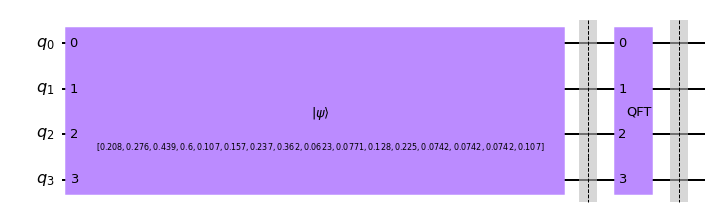

In [13]:
def apply_qft(qc,n):
    qc.append(QFT(n), qc.qubits)
    return qc

## Function to measure the image state

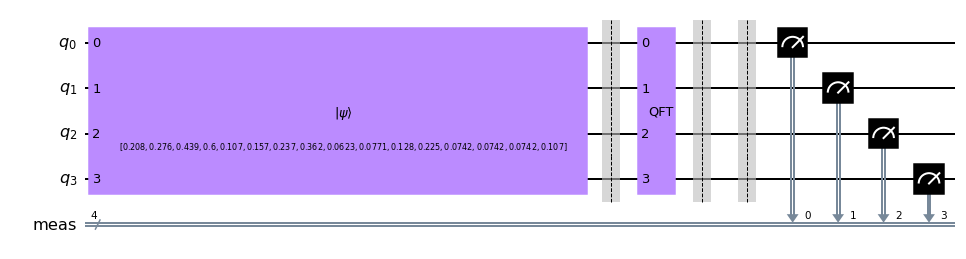

In [14]:
def measurement_and_retrieval(qc,n):
    
    #Measure the state
    qc.measure_all()
    
    #Get the probability amplitudes
    aer_sim = Aer.get_backend('aer_simulator')
    shots = 4096
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    fourier_transformed_array = np.zeros(2**n,dtype=float)
    bin_var = 0b0000
    dict_list = counts.keys()
    for i in range(2**n):
        str_var = bin(bin_var)[2:]
        str_var = str_var.zfill(n)
        if str_var in dict_list:
            fourier_transformed_array[i] = counts[f'{str_var}']/shots
            fourier_transformed_array[i] = np.sqrt(fourier_transformed_array[i])
        else:
            fourier_transformed_array[i] = 0
        bin_var += 1
    
    # Get the pixel values
    fourier_transformed_array = fourier_transformed_array*255
    transformed_pixel_data = np.zeros(2**n, dtype=int)
    for i in range(2**n): transformed_pixel_data[i] = int(fourier_transformed_array[i])
    picture_array = np.asarray([[0 for i in range(size)] for j in range(size)])
    for i in range(2**n):
        picture_array[i//size][i%size] = transformed_pixel_data[i]
    
    return picture_array

## Function to retrieve the image

In [ ]:
def retrieve_image(picture_array)
    picture_array = picture_array.astype(np.uint8)
    new_image = Image.fromarray(picture_array)
    new_image.save('new_image.png')
    
    return None

## Measuring and Image Retrieval

{'0100': 188, '0000': 2610, '0010': 98, '1100': 174, '0101': 33, '1110': 102, '1111': 256, '0001': 271, '1010': 9, '1000': 81, '0111': 13, '1001': 31, '0011': 91, '0110': 22, '1101': 81, '1011': 36}


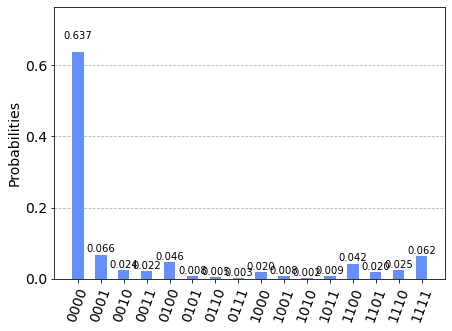

In [15]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=shots)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [150]:
fourier_transformed_array = np.zeros(16,dtype=float)
bin_var = 0b0000
for i in range(16):
    str_var = bin(bin_var)[2:]
    fourier_transformed_array[i] = counts[f'{str_var.zfill(4)}']/shots
    fourier_transformed_array[i] = np.sqrt(fourier_transformed_array[i])
    bin_var += 1
fourier_transformed_array

array([0.80237075, 0.25339492, 0.14657549, 0.13258252, 0.18421603,
       0.0841432 , 0.0681078 , 0.08118988, 0.14490029, 0.06987712,
       0.07160275, 0.09375   , 0.21079277, 0.1457403 , 0.15309311,
       0.26791294])

### Getting the pixel values

In [153]:
fourier_transformed_array = fourier_transformed_array*16777215
transformed_pixel_data = np.zeros(16, dtype=int)
for i in range(16): transformed_pixel_data[i] = int(fourier_transformed_array[i])
transformed_pixel_data

array([13461546,  4251261,  2459128,  2224365,  3090631,  1411688,
        1142659,  1362140,  2431023,  1172343,  1201294,  1572863,
        3536515,  2445116,  2568476,  4494833])

In [154]:
picture_array = np.asarray([[[0 for i in range(3)] for j in range(4)] for k in range(4)])
for i in range(16):
    picture_array[i//4][i%4][2] = transformed_pixel_data[i]%256
    picture_array[i//4][i%4][1] = int(((transformed_pixel_data[i]%65536)-(picture_array[i//4][i%4][2]))/256)
    picture_array[i//4][i%4][0] = int(transformed_pixel_data[i]/65536)
picture_array

array([[[205, 104,  42],
        [ 64, 222, 125],
        [ 37, 133, 248],
        [ 33, 240, 237]],

       [[ 47,  40, 199],
        [ 21, 138, 104],
        [ 17, 111, 131],
        [ 20, 200, 220]],

       [[ 37,  24,  47],
        [ 17, 227, 119],
        [ 18,  84, 142],
        [ 23, 255, 255]],

       [[ 53, 246, 131],
        [ 37,  79,  60],
        [ 39,  49,  28],
        [ 68, 149, 241]]])

### Retrieval

In [156]:
picture_array = picture_array.astype(np.uint8)
new_image = Image.fromarray(picture_array)
new_image.save('new3.png')